In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle

## load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

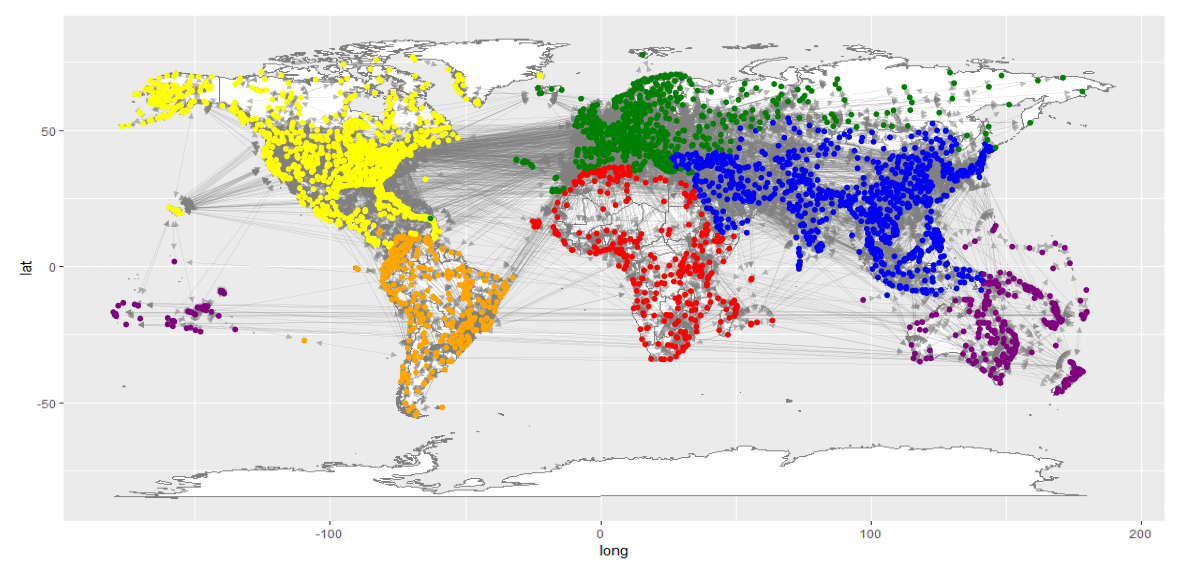

In [4]:
positions = {k: (v['longitude'], v['latitude']) for k, v in IATA.items()}
continent_to_color = {
    'Africa': 'red',
    'Asia': 'blue',
    'Europe': 'green',
    'North America': 'yellow',
    'Oceania': 'purple',
    'South America': 'orange',
    'unknown': 'black'
}
colors = [continent_to_color[G.nodes[n]['continent']] for n in G.nodes]

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
worldmap = plt.imread('images/worldmap.png')

# left, right, bottom, top = -150, 150, -50, 75
# plt.scatter([0, 0, left, right], [bottom, top, 0, 0], c='black', s=10)

plt.imshow(worldmap, zorder=0, extent=[-218, 211, -110, 95])      ## magic constants
nx.draw_networkx_nodes(G, positions, node_color=colors, node_size=10)
nx.draw_networkx_edges(G, positions, edge_color='gray', alpha=0.5, width=0.1)
plt.axis('off')
plt.savefig('images/airports.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
import netwulf as nw
nw.visualize(G)

(None, None)

Nodes with the highest degree:  [('FRA', 477), ('CDG', 470), ('AMS', 463), ('IST', 455), ('ATL', 433), ('ORD', 409), ('PEK', 408), ('MUC', 380), ('DME', 376), ('DFW', 372)]


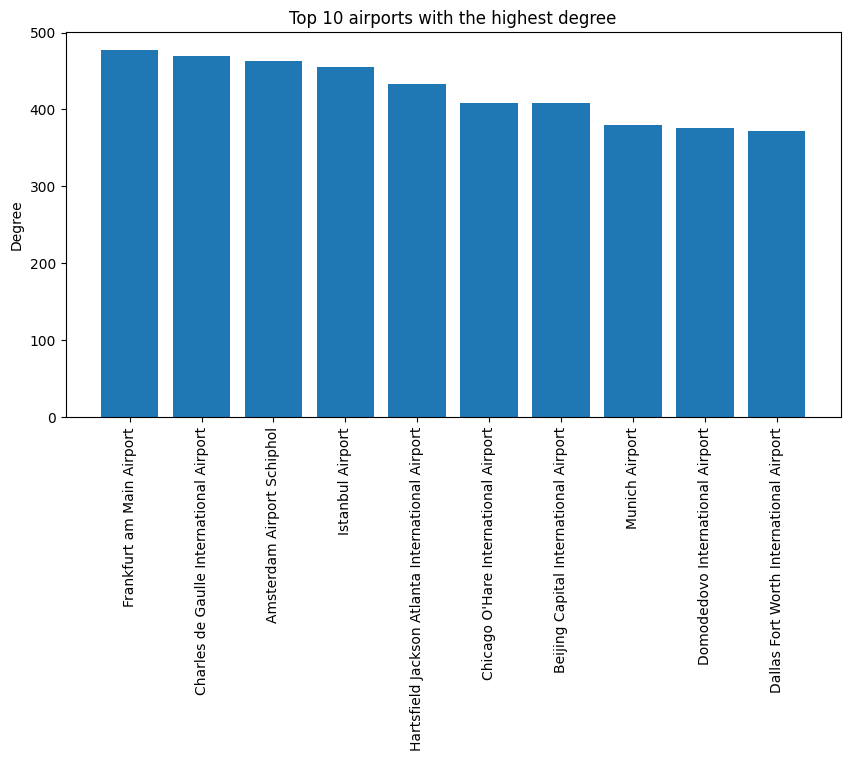

Edges with the highest weight:  [(('ORD', 'ATL'), 20), (('ATL', 'ORD'), 19), (('HKT', 'BKK'), 13), (('ORD', 'MSY'), 13), (('LHR', 'JFK'), 12), (('AUH', 'MCT'), 12), (('HKG', 'BKK'), 12), (('CAN', 'HGH'), 12), (('MIA', 'ATL'), 12), (('ATL', 'MIA'), 12)]


In [29]:
## find nodes with the highest degree
## make a bar plot of the top 10
## on the x-axis, put the airport city name
## on the y-axis, put the degree of the airport
degrees = dict(G.degree())
sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Nodes with the highest degree: ", sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10, 5))
plt.bar([G.nodes[k]["name"] for k, v in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]],
        [v for k, v in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]])
plt.xticks(rotation=90)
plt.ylabel('Degree')
plt.title('Top 10 airports with the highest degree')
plt.savefig('images/top10_airports_degree.png', dpi=300, bbox_inches='tight')
plt.show()



## find the edges with the highest weight
weights = nx.get_edge_attributes(G, 'weight')
sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10]
print("Edges with the highest weight: ", sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

In [23]:
G.nodes["GKA"]

{'city': 'Goroka',
 'country': 'Papua New Guinea',
 'latitude': -6.081689834590001,
 'longitude': 145.391998291,
 'continent': 'Oceania',
 'name': 'Goroka Airport',
 'group': 'Oceania'}